In [1]:
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
plt.style.use('classic')

In [2]:
def read_metric_from_file(path):
    return json.load(path.open("r"))

columns = ["Sacrifice Ratio", "Unsatisfaction Mean", "Unsatisfaction Std", "Weighted Objective"]

def read_data(output_dir, filename, params, num_seed=0):
    metrics = defaultdict(list)
    for param in params:
        if num_seed == 0:
            path = Path(output_dir) / (filename.format(param).replace(".", "_") + ".json")
            metric = read_metric_from_file(path)
            for key in columns:
                metrics[key].append(float(metric[key]))
        else:
            metrics_ = defaultdict(list)
            for seed in range(1, num_seed + 1):
                path = Path(output_dir) / (filename.format(param, seed).replace(".", "_") + ".json")
                metric = read_metric_from_file(path)
                for key in columns:
                    metrics_[key].append(float(metric[key]))
            for key in metrics_:
                data = np.array(metrics_[key])
                metrics[f"{key}_mean"].append(data.mean())
                metrics[f"{key}_std"].append(data.std())
    return metrics

def read_olp_data(output_dir, filename, params, lr_params=[10.0, 5.0,  1.0, .1, .01, .001, .0001], init_params=["zero", "one"]):
    metrics = defaultdict(list)
    for param in params:
        best_weighted_objective = -np.inf
        best_metric = None
        for lr in lr_params:
            for init in init_params:
                path = Path(output_dir) / (filename.format(param, init, lr).replace(".", "_") + ".json")
                metric = read_metric_from_file(path)
                if float(metric["Weighted Objective"]) > best_weighted_objective:
                    best_metric = metric
                    best_weighted_objective = float(metric["Weighted Objective"])
        for key in columns:
            metrics[key].append(float(best_metric[key]))       
    return metrics


In [3]:
def result_plot(metrics, param_name, params, xaxis_log=False, xlabel=None, errorbar=False, base_metrics=None):
    columns = ["Sacrifice Ratio", "Unsatisfaction Mean", "Unsatisfaction Std", "Weighted Objective"]
    column_to_title = {"Sacrifice Ratio":"Sacrifice Ratio",
                      "Unsatisfaction Mean": "Uns. Mean",
                      "Unsatisfaction Std": "Uns. Std",
                      "Weighted Objective": "."}
    
    fig, axes= plt.subplots(nrows = 1, ncols = 4, figsize=(16,4))
    show_legend = not isinstance(metrics, defaultdict)
    for i in range(4):
        ax = axes[i]
        key = columns[i]
        if show_legend:
            if base_metrics:
                for x in base_metrics:
                    color = base_metrics[x][1]
                    y = base_metrics[x][0][key]
                    print(y)
                    print(np.around(float(y), 2))
                    ax.axhline(y = np.around(float(y), 2), linestyle='--', color=color, label=x)
            for x in metrics:
                color = metrics[x][1]
                linestyle='-' if x.startswith('MPC') else '--'
                if errorbar:
                    mean = metrics[x][0][f"{key}_mean"]
                    std = metrics[x][0][f"{key}_std"]
                    ax.errorbar(params, mean, yerr=std, linestyle=linestyle, label=x, color=color)
                else:
                    y = metrics[x][0][key]
                    ax.plot(params, y, label=x, color=color, linestyle=linestyle)
        else:
            if errorbar:
                mean = metrics[f"{key}_mean"]
                std = metrics[f"{key}_std"]
                ax.errorbar(params, mean, yerr=std)
            else:
                print(key)
                print(metrics)
                y = metrics[key]
                print(y)
                ax.plot(params, y)
        ax.set_title(key)
        ax.set_xlabel(xlabel)
        if base_metrics:
            if key == 'Sacrifice Ratio':
                ax.set_ylim(-0.001, .006)
            elif key == 'Unsatisfaction Mean':
                ax.set_ylim(-0.1, 0.40)
            elif key == 'Unsatisfaction Std':
                ax.set_ylim(-0.1, 0.40)
            elif key == 'Weighted Objective':
                ax.set_ylim(1 + 2e3, 14 + 2e3)
        
        if xaxis_log:
           ax.set_xscale('log')
        
    fig.suptitle(param_name, fontsize="large")
    lines_labels = [ax.get_legend_handles_labels() for idx, ax in enumerate(fig.axes[:1])]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=False, ncol=4, frameon=False, fontsize="medium")
    fig.tight_layout()
    fig.show()

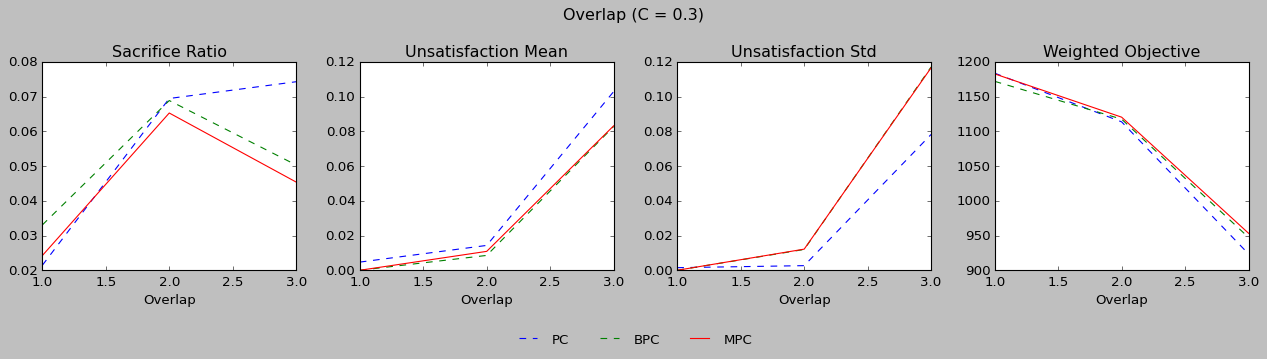

In [6]:
param_name = "Overlap (C = 0.3)"
params = [1, 2, 3]
metrics = {"PC": (read_data("outputs/overlap/", "{}/lastfm/pc_c_0_3", params, 0), "blue"),
"BPC": (read_data("outputs/overlap/", "{}/lastfm/bpc_c_0_3", params, 0), "green"),
"MPC": (read_data("outputs/overlap/", "{}/lastfm/smpca_c_0_3_b_50_bo_10", params, 0), "red")}#,
result_plot(metrics, param_name, params, xaxis_log=False, xlabel='Overlap', errorbar=False)